# Taller: Transformaciones Geométricas 2D
## Computación Visual · Semana 1

En este cuaderno se estudian las tres transformaciones geométricas fundamentales en 2D:

| Transformación | Descripción | Parámetros |
|---|---|---|
| **Traslación** | Mueve el objeto en el plano | $t_x, t_y$ |
| **Rotación** | Gira el objeto alrededor del origen | $\theta$ (radianes) |
| **Escala** | Cambia el tamaño del objeto | $s_x, s_y$ |

Cada operación se expresa con matrices homogéneas de tamaño 3×3, lo que permite componer varias transformaciones con una sola multiplicación matricial:

$$P' = T \cdot R \cdot S \cdot P$$

La figura base será un cuadrado unitario centrado en el origen.

## 1. Carga de librerías

In [1]:
%%capture

%pip install numpy matplotlib imageio ipython

In [2]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
import imageio.v2 as imageio
from IPython.display import Image, display

WORK_DIR = "output"
FINAL_GIF_FILE = "/media/python.gif"
os.makedirs(WORK_DIR, exist_ok=True)

print("✅ Dependencias listas.")

✅ Dependencias listas.


## 2. Figura Base: Cuadrado 2D en Coordenadas Homogéneas

El cuadrado se representa como una matriz **3×N**, donde cada columna corresponde a un punto $(x, y, 1)^T$.  
La tercera coordenada fija en `1` permite incorporar la traslación en la misma operación matricial.

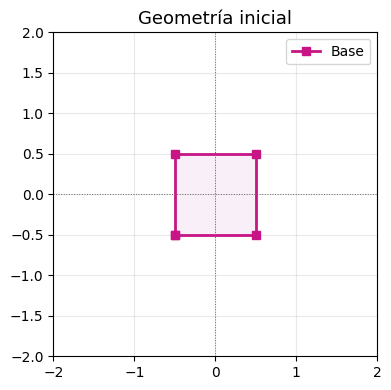

Matriz homogénea base (3×5):
[[-0.5  0.5  0.5 -0.5 -0.5]
 [-0.5 -0.5  0.5  0.5 -0.5]
 [ 1.   1.   1.   1.   1. ]]


In [3]:
def generate_unit_square(edge=1.0):
    """
    Construye un cuadrado centrado en (0,0) en coordenadas homogéneas.
    Devuelve un arreglo de forma (3, 5), cerrando el contorno.
    """
    semi = edge * 0.5
    contour = np.array([
        [-semi, -semi],
        [ semi, -semi],
        [ semi,  semi],
        [-semi,  semi],
        [-semi, -semi],
    ], dtype=float).T

    homog_row = np.ones((1, contour.shape[1]))
    return np.vstack((contour, homog_row))


# ─── Vista de la geometría base ──────────────────────────────────────────────
shape0 = generate_unit_square(edge=1.0)

fig, panel = plt.subplots(figsize=(4, 4))
panel.plot(shape0[0], shape0[1], color='mediumvioletred', marker='s', linewidth=2, markersize=6, label='Base')
panel.fill(shape0[0, :-1], shape0[1, :-1], alpha=0.16, color='plum')
panel.axhline(0, color='dimgray', linewidth=0.7, linestyle=':')
panel.axvline(0, color='dimgray', linewidth=0.7, linestyle=':')
panel.set_xlim(-2, 2); panel.set_ylim(-2, 2)
panel.set_aspect('equal'); panel.grid(True, alpha=0.28)
panel.set_title("Geometría inicial", fontsize=13)
panel.legend()
plt.tight_layout()
plt.show()

print(f"Matriz homogénea base (3×5):\n{shape0}")

## 3. Matrices de Transformación Homogéneas (3×3)

### Traslación $T(t_x, t_y)$
$$T = \begin{pmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{pmatrix}$$

### Rotación $R(\theta)$
$$R = \begin{pmatrix} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{pmatrix}$$

### Escala $S(s_x, s_y)$
$$S = \begin{pmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \\ 0 & 0 & 1 \end{pmatrix}$$

### Transformación Compuesta
$$M = T \cdot R \cdot S$$
El orden de multiplicación es clave: primero se escala, después se rota y al final se traslada.

In [4]:
def shift_matrix(dx, dy):
    """Matriz homogénea de traslación 2D."""
    return np.array([
        [1, 0, dx],
        [0, 1, dy],
        [0, 0,  1],
    ], dtype=float)

def spin_matrix(angle_rad):
    """Matriz homogénea de rotación 2D (sentido antihorario)."""
    cosine, sine = np.cos(angle_rad), np.sin(angle_rad)
    return np.array([
        [ cosine, -sine, 0],
        [ sine,  cosine, 0],
        [ 0,  0, 1],
    ], dtype=float)

def resize_matrix(scale_x, scale_y):
    """Matriz homogénea de escala 2D."""
    return np.array([
        [scale_x,      0, 0],
        [     0, scale_y, 0],
        [ 0,  0, 1],
    ], dtype=float)

def run_affine(transform_3x3, cloud_3xn):
    """Aplica la transformación afín sobre puntos homogéneos."""
    return transform_3x3 @ cloud_3xn


# ─── Inspección rápida de matrices ───────────────────────────────────────────
print("Shift(2, 1):\n", shift_matrix(2, 1))
print("\nSpin(45°):\n", np.round(spin_matrix(np.radians(45)), 3))
print("\nResize(2, 0.5):\n", resize_matrix(2, 0.5))
print("\nComposición Shift·Spin·Resize:\n", np.round(shift_matrix(2, 1) @ spin_matrix(np.radians(45)) @ resize_matrix(2, 0.5), 3))

Shift(2, 1):
 [[1. 0. 2.]
 [0. 1. 1.]
 [0. 0. 1.]]

Spin(45°):
 [[ 0.707 -0.707  0.   ]
 [ 0.707  0.707  0.   ]
 [ 0.     0.     1.   ]]

Resize(2, 0.5):
 [[2.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]

Composición Shift·Spin·Resize:
 [[ 1.414 -0.354  2.   ]
 [ 1.414  0.354  1.   ]
 [ 0.     0.     1.   ]]


## 4. Transformaciones Estáticas

Se aplica cada transformación por separado y luego la composición **T·R·S** sobre la figura base.

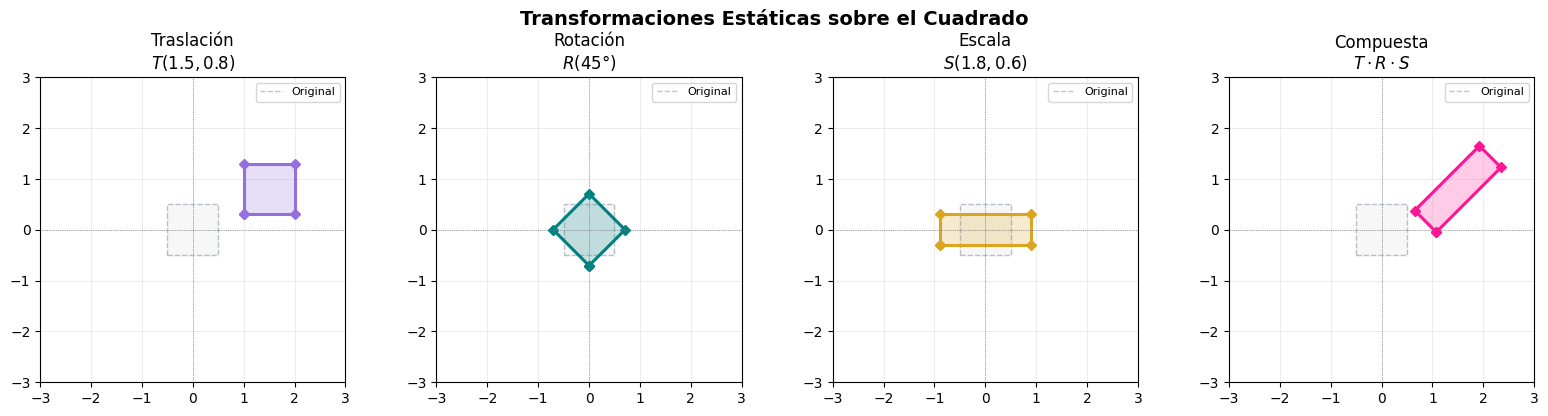

In [5]:
shape0 = generate_unit_square(edge=1.0)

# ── Parámetros de demostración ───────────────────────────────────────────────
dx, dy      = 1.5, 0.8
angle_demo  = np.radians(45)
sc_x, sc_y  = 1.8, 0.6

shape_shift   = run_affine(shift_matrix(dx, dy), shape0)
shape_spin    = run_affine(spin_matrix(angle_demo), shape0)
shape_resize  = run_affine(resize_matrix(sc_x, sc_y), shape0)
shape_total   = run_affine(shift_matrix(dx, dy) @ spin_matrix(angle_demo) @ resize_matrix(sc_x, sc_y), shape0)

# ── Visualización ─────────────────────────────────────────────────────────────
fig, axis_row = plt.subplots(1, 4, figsize=(16, 4))
cards = [
    (shape_shift,  "Traslación\n$T(1.5, 0.8)$", 'mediumpurple'),
    (shape_spin,   "Rotación\n$R(45°)$",       'teal'),
    (shape_resize, "Escala\n$S(1.8, 0.6)$",    'goldenrod'),
    (shape_total,  "Compuesta\n$T \\cdot R \\cdot S$", 'deeppink'),
]

for axis, (cloud, caption, pigment) in zip(axis_row, cards):
    axis.plot(shape0[0], shape0[1], linestyle='--', color='slategray', linewidth=1, alpha=0.45, label='Original')
    axis.fill(shape0[0, :-1], shape0[1, :-1], alpha=0.06, color='gray')
    axis.plot(cloud[0], cloud[1], color=pigment, linewidth=2.2, marker='D', markersize=5)
    axis.fill(cloud[0, :-1], cloud[1, :-1], alpha=0.22, color=pigment)
    axis.axhline(0, color='gray', linewidth=0.6, linestyle=':')
    axis.axvline(0, color='gray', linewidth=0.6, linestyle=':')
    axis.set_xlim(-3, 3); axis.set_ylim(-3, 3)
    axis.set_aspect('equal'); axis.grid(True, alpha=0.22)
    axis.set_title(caption, fontsize=12)
    axis.legend(fontsize=8)

plt.suptitle("Transformaciones Estáticas sobre el Cuadrado", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Animación temporal de la transformación

Se genera una secuencia de `FRAME_TOTAL` cuadros. En cada frame se evalúa $t \in [0,1)$ y se actualizan traslación, rotación y escala.

Además, se muestra la matriz compuesta $M(t)$ en distintos instantes para observar su evolución temporal.

In [6]:
FRAME_TOTAL = 72
shape0 = generate_unit_square(edge=1.0)
gif_stack = []
matrix_log = []

for frame_idx in range(FRAME_TOTAL):
    tau = frame_idx / FRAME_TOTAL

    dx_t = 2.0 * np.cos(2.0 * np.pi * tau)
    dy_t = 2.0 * np.sin(2.0 * np.pi * tau)
    ang_t = 2.0 * np.pi * tau
    scl_t = 0.5 + np.sin(np.pi * tau) ** 2

    affine_t = shift_matrix(dx_t, dy_t) @ spin_matrix(ang_t) @ resize_matrix(scl_t, scl_t)
    shape_t = run_affine(affine_t, shape0)
    matrix_log.append((frame_idx, tau, affine_t))

    fig, axis = plt.subplots(figsize=(5, 5), dpi=100)

    ring = np.linspace(0, 2.0 * np.pi, 220)
    axis.plot(2.0 * np.cos(ring), 2.0 * np.sin(ring), linestyle='--', color='lavender', linewidth=1.1)

    axis.fill(shape0[0, :-1], shape0[1, :-1], alpha=0.08, color='powderblue')
    axis.plot(shape0[0], shape0[1], linestyle='--', color='cadetblue', linewidth=1, alpha=0.45)

    axis.fill(shape_t[0, :-1], shape_t[1, :-1], alpha=0.45, color='orchid')
    axis.plot(shape_t[0], shape_t[1], color='purple', marker='o', linewidth=2, markersize=5)

    axis.axhline(0, color='gray', linewidth=0.6, linestyle=':', alpha=0.55)
    axis.axvline(0, color='gray', linewidth=0.6, linestyle=':', alpha=0.55)
    axis.set_xlim(-3.8, 3.8)
    axis.set_ylim(-3.8, 3.8)
    axis.set_aspect('equal')
    axis.grid(True, alpha=0.22)
    axis.set_title(
        f"Frame {frame_idx + 1:02d}/{FRAME_TOTAL} — t={tau:.2f}\n"
        f"tx={dx_t:.2f}, ty={dy_t:.2f}, θ={np.degrees(ang_t):.0f}°, s={scl_t:.2f}"
    )

    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    rgb_frame = np.asarray(canvas.buffer_rgba())[..., :3]
    gif_stack.append(rgb_frame)
    plt.close(fig)

print(f"✅ Frames generados: {len(gif_stack)}")
print("\nMatriz compuesta M(t) en muestras de tiempo:")
for idx in [0, FRAME_TOTAL // 4, FRAME_TOTAL // 2, (3 * FRAME_TOTAL) // 4, FRAME_TOTAL - 1]:
    f_idx, tau, mat = matrix_log[idx]
    print(f"\nFrame {f_idx + 1:02d} (t={tau:.2f})")
    print(np.round(mat, 3))

✅ Frames generados: 72

Matriz compuesta M(t) en muestras de tiempo:

Frame 01 (t=0.00)
[[0.5 0.  2. ]
 [0.  0.5 0. ]
 [0.  0.  1. ]]

Frame 19 (t=0.25)
[[ 0. -1.  0.]
 [ 1.  0.  2.]
 [ 0.  0.  1.]]

Frame 37 (t=0.50)
[[-1.5 -0.  -2. ]
 [ 0.  -1.5  0. ]
 [ 0.   0.   1. ]]

Frame 55 (t=0.75)
[[-0.  1. -0.]
 [-1. -0. -2.]
 [ 0.  0.  1.]]

Frame 72 (t=0.99)
[[ 0.5    0.044  1.992]
 [-0.044  0.5   -0.174]
 [ 0.     0.     1.   ]]


⚠️ Sin permisos para /media; se guardó en fallback local.
✅ GIF guardado en: output/python.gif


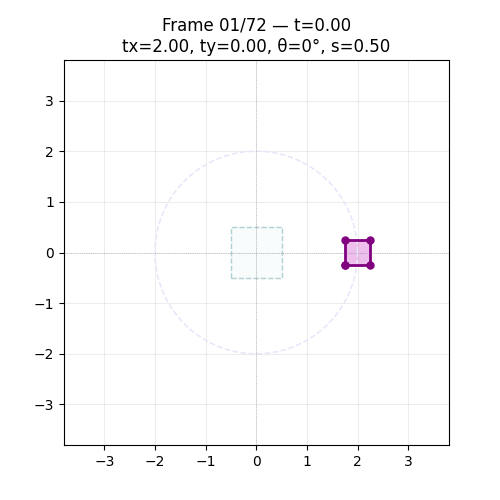

In [9]:
# Exporta GIF: intenta /media/python.gif y usa fallback si no hay permisos
TARGET_GIF = "/media/python.gif"
FALLBACK_GIF = os.path.join(WORK_DIR, "python.gif")

try:
    os.makedirs(os.path.dirname(TARGET_GIF), exist_ok=True)
    imageio.mimsave(TARGET_GIF, gif_stack, fps=20, loop=0)
    GIF_PATH = TARGET_GIF
except PermissionError:
    imageio.mimsave(FALLBACK_GIF, gif_stack, fps=20, loop=0)
    GIF_PATH = FALLBACK_GIF
    print("⚠️ Sin permisos para /media; se guardó en fallback local.")

print(f"✅ GIF guardado en: {GIF_PATH}")
display(Image(filename=GIF_PATH, width=420))

In [10]:
# Comprobación rápida de existencia del archivo final
print("Ruta final:", GIF_PATH)
print("Existe GIF:", os.path.exists(GIF_PATH))
print("Tamaño (bytes):", os.path.getsize(GIF_PATH) if os.path.exists(GIF_PATH) else 0)

Ruta final: output/python.gif
Existe GIF: True
Tamaño (bytes): 438274
